In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(50), nn.ReLU(),
            nn.LazyLinear(num_classes))

In [3]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 32, 28, 28])
ReLU output shape:	 torch.Size([1, 32, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 32, 14, 14])
Conv2d output shape:	 torch.Size([1, 64, 14, 14])
ReLU output shape:	 torch.Size([1, 64, 14, 14])
MaxPool2d output shape:	 torch.Size([1, 64, 7, 7])
Conv2d output shape:	 torch.Size([1, 128, 7, 7])
ReLU output shape:	 torch.Size([1, 128, 7, 7])
MaxPool2d output shape:	 torch.Size([1, 128, 3, 3])
Flatten output shape:	 torch.Size([1, 1152])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 50])
ReLU output shape:	 torch.Size([1, 50])
Linear output shape:	 torch.Size([1, 10])


/Users/muazbinkashif/Documents/Duke Fall 2023/ENERGY 395T /venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


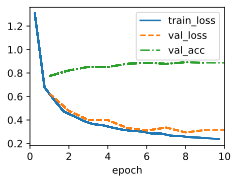

In [4]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
'''
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def get_activations(model, x):
    activations = []
    for i, layer in enumerate(model.net):
        x = layer(x)
        if i == 1 or i == 2:  
            activations.append(x)
        if i >= 4: 
            break
    return activations

sweater_images = []
coat_images = []

for images, labels in test_loader:
    for i, label in enumerate(labels):
        if label == 2:
            sweater_images.append(images[i])
        elif label == 4: 
            coat_images.append(images[i])
    if len(sweater_images) >= 10 and len(coat_images) >= 10:
        break

sweater_images = torch.stack(sweater_images)[:10]
coat_images = torch.stack(coat_images)[:10]

sweater_activations = get_activations(model, sweater_images)
coat_activations = get_activations(model, coat_images)

import matplotlib.pyplot as plt

def visualize_activations(activations, title):
    num_activations = activations.shape[1]
    fig, axes = plt.subplots(1, num_activations, figsize=(num_activations * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(activations[0][i].detach().numpy(), cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()


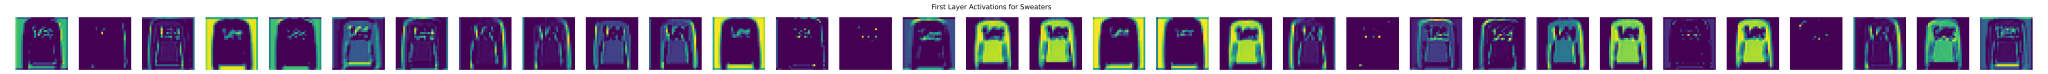

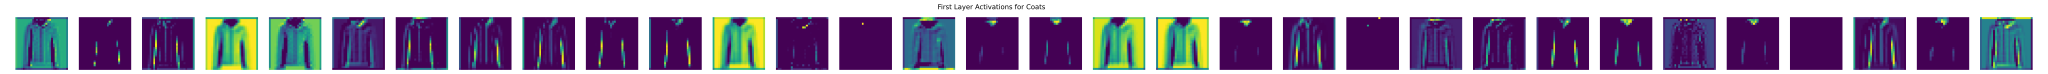

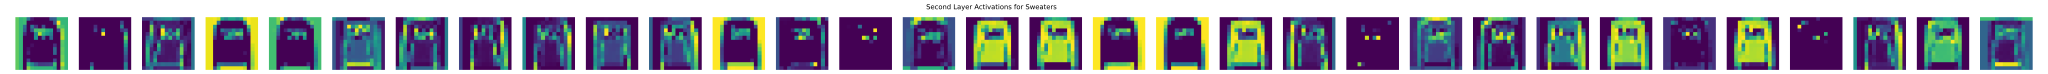

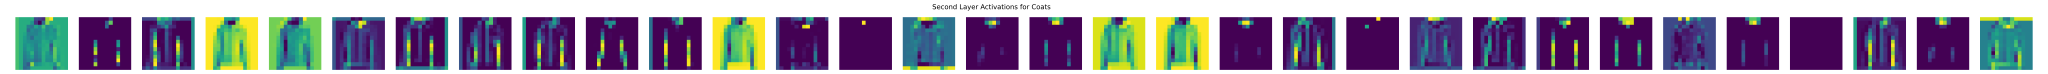

In [8]:
visualize_activations(sweater_activations[0], 'First Layer Activations for Sweaters')
visualize_activations(coat_activations[0], 'First Layer Activations for Coats')
visualize_activations(sweater_activations[1], 'Second Layer Activations for Sweaters')
visualize_activations(coat_activations[1], 'Second Layer Activations for Coats')